# Clustering FOX Data #

In this notebook I try Kmeans clustering on FOX data to see if automatically assigned clusters can help determine which sentences are ads.

In [1]:
import re

import pandas as pd

import matplotlib.pyplot as plt

import pickle

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

In [2]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\linne\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
fox_df = pd.read_csv('../data/interim/fox-last-year-sent-comb.csv')
fox_df.head()

,Unnamed: 0,Unnamed: 0.1,sentence,start_snip,end_snip,contributor,runtime,start_time,stop_time,identifier,subjects
0,0,0,week.,0,60,FOXNEWSW,01:00:58,2019-05-28 01:00:00,2019-05-28 02:00:59,FOXNEWSW_20190528_010000_Hannity_Memorial_Day_...,"['biden', 'russia', 'alec baldwin', 'donald tr..."
1,1,1,tucker: tune in every night to the sworn enem...,0,60,FOXNEWSW,01:00:58,2019-05-28 01:00:00,2019-05-28 02:00:59,FOXNEWSW_20190528_010000_Hannity_Memorial_Day_...,"['biden', 'russia', 'alec baldwin', 'donald tr..."
2,2,2,have a great memorial day evening. see you tom...,0,60,FOXNEWSW,01:00:58,2019-05-28 01:00:00,2019-05-28 02:00:59,FOXNEWSW_20190528_010000_Hannity_Memorial_Day_...,"['biden', 'russia', 'alec baldwin', 'donald tr..."
3,3,4,"sean: looking to the special edition of ""ha...",0,60,FOXNEWSW,01:00:58,2019-05-28 01:00:00,2019-05-28 02:00:59,FOXNEWSW_20190528_010000_Hannity_Memorial_Day_...,"['biden', 'russia', 'alec baldwin', 'donald tr..."
4,4,5,let's go to a flashback.,0,60,FOXNEWSW,01:00:58,2019-05-28 01:00:00,2019-05-28 02:00:59,FOXNEWSW_20190528_010000_Hannity_Memorial_Day_...,"['biden', 'russia', 'alec baldwin', 'donald tr..."


In [4]:
len(fox_df)

2474856

This is a massive dataset, nearly 3 million sentences, so I'm going to get a random 10% of it to work with.

In [6]:
fox_df, _ = train_test_split(fox_df.drop(columns=['Unnamed: 0', 
                                                  'Unnamed: 0.1']).dropna(), test_size=0.9, random_state=18)
len(fox_df)

247485

In [7]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could',
                           '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many',
                           'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily',
                           'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right',
                           'line', 'even', 'also', 'may', 'take', 'come', 'hi', 'ha', 'le', 'u', 'wa', 'thi',
                           'to', 'one'])

In [8]:
def clean_sent(sentences):
    for sent in sentences:
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = re.sub("([\d,\,\./!#$%&\'\":;>\?@\[\]`)(\+])+", "", sent) # remove digits and remove punctuation
        sent = re.sub("([-])+", " ", sent)
        yield(sent)  

In [9]:
corpus = list(clean_sent(fox_df.sentence.values.tolist()))
corpus[:5]

['i happen to pick those out when i was running out but off the',
 'iranian aggression mustem be checked or it will get worse',
 'big papis wife said doctors ungraded his condition to good',
 ' simple',
 'i think is you just heard because as both a hate crime and domestic terror and federal law has a crime and provisions just like state laws in new jersey you could have a joy federal state investigation and can have a federal prosecution anybody that was found would be justice liable to a serious sentence as the primary assailants themselves were killed']

From some previous experimentation with Fox data, I found that TfidF vectorization with bigrams gave the easiest-to-interpret kmeans clusters and that 75 clusters separated out a lot of ad copy

In [10]:
#lemmatize before vectorizing

class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

vect = TfidfVectorizer(tokenizer=LemmaTokenizer(), strip_accents='unicode', stop_words='english', 
                       min_df=2, max_df=0.3, ngram_range=(2,2))

In [11]:
pickle.dump(vect, open('../models/fox_vect.p', 'wb'))

In [12]:
fox_bow = vect.fit_transform(corpus)
vect.get_feature_names()

C:\Users\linne\Anaconda3\envs\ad-finder-cc\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


['* im',
 'TM lens',
 '^ caret',
 'aa battery',
 'aag best',
 'aag introducing',
 'aag leader',
 'aag trust',
 'aag working',
 'aags free',
 'aags new',
 'aaron judge',
 'aarp ha',
 'aarp high',
 'aarp medicare',
 'aarp thats',
 'abaco grand',
 'abaco island',
 'abandoned district',
 'abandoned kurd',
 'abbott make',
 'abbott saying',
 'abbott taking',
 'abbott technology',
 'abby fox',
 'abby hornacek',
 'abby phillips',
 'abby welcome',
 'abc anchor',
 'abc cbs',
 'abc editorial',
 'abc executive',
 'abc news',
 'abc panel',
 'abc poll',
 'abc victim',
 'abc week',
 'abca fox',
 'abdication oath',
 'abdomen pain',
 'abdominal shoulder',
 'abducted choked',
 'abe japan',
 'abfrankly youre',
 'abide law',
 'abide rule',
 'abiding american',
 'abiding bheem',
 'abiding citizen',
 'abiding gun',
 'abiding people',
 'abigail grace',
 'ability able',
 'ability american',
 'ability argument',
 'ability believing',
 'ability bring',
 'ability build',
 'ability business',
 'ability candidate'

In [13]:
kmeans = KMeans(n_clusters=75, random_state=18)
results = kmeans.fit_predict(fox_bow)
pickle.dump(kmeans, open('../models/fox_kmeans.p', 'wb'))

In [14]:
#print out most indicative words
terms = vect.get_feature_names()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
for i in range(75):
    print ("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print (' %s' % terms[ind])
    print()

Cluster 0:
 medicare supplement
 supplement plan
 look medicare
 aarp medicare
 help pay
 plan help
 humana just
 like humana
 just answer
 plan company

Cluster 1:
 president trump
 dont know
 joe biden
 donald trump
 white house
 dont think
 bernie sander
 american people
 little bit
 cy pelosi

Cluster 2:
 control business
 business little
 little intense
 lack control
 cobra kai
 started cobra
 kai lack
 guard watching
 guardian newspaper
 guard virus

Cluster 3:
 air frying
 cooking air
 pressure cooking
 best pressure
 frying pot
 pot tendercrisp
 tendercrisp technology
 cook food
 food crispy
 crispy outside

Cluster 4:
 secretary state
 mike pompeo
 state mike
 state pompeo
 wa secretary
 assistant secretary
 president secretary
 pompeo secretary
 state george
 talking secretary

Cluster 5:
 fox news
 news alert
 news contributor
 begin fox
 news channel
 news sunday
 sandra fox
 tell fox
 right fox
 joining u

Cluster 6:
 camera figure
 figure wa
 wa easy
 guess competition
 g

I did attempt other types of clustering algorithms, but they all killed my computer with even 10,000 sentences, so I've stuck with KMeans and LDA (to follow).

In [15]:
# add results to fox data frame
fox_df['cluster'] = results

In [16]:
# view sentences for each cluster
file_contents = ''
for i in range(75):
    file_contents += 'Cluster {}\n'.format(i)
    counter = 0
    for index, row in fox_df[fox_df.cluster == i].iterrows():
        file_contents += row['sentence'] + '\n'
        counter += 1
        if counter > 20:
            break
    file_contents += '\n'
with open('../data/interim/fox-sentence-check-20200611.txt', 'w') as f:
    f.write(file_contents)

In [17]:
# count number of sentences in each cluster
fox_df[['cluster', 'sentence']].groupby('cluster').count().sort_values(by='sentence', ascending=False)

,sentence
cluster,
1,236672
50,1953
8,1628
5,1144
71,659
...,...
68,4
45,4
30,4


Clearly Cluster 1 has the vast majority of the sentences in it. Kmeans clustering, at least with this number of clusters, is not effective on its own but does help pick out some ads with repetitive copy, and so clusters may be an effective feature for future supervised learning.

I can see that clusters with a smaller vocabulary are more likely to be ads. This might be something to look at in the future.

I manually assigned all the clusters to be ad clusters, news clusters, or mixed, and then added that information to the dataframe.

In [18]:
ad_clusters = [0, 2, 3, 6, 9, 11, 15, 16, 17, 18, 20, 21, 22, 23, 29, 30, 33, 34, 37,
              39, 41, 42, 45, 47, 49, 51, 55, 56, 58, 61, 62, 65, 66, 67, 69, 73]
news_clusters = [4, 5, 7, 8, 10, 12, 13, 14, 19, 24, 25, 26, 27, 28, 31, 32, 35, 36,
                38, 40, 43, 44, 46, 48, 50, 52, 53, 54, 57, 59, 60, 63, 64, 68, 70, 71,
                72, 74]
mixed = [1]

fox_df['ad_cluster'] = 0
fox_df['news_cluster'] = 0
fox_df.head()

,sentence,start_snip,end_snip,contributor,runtime,start_time,stop_time,identifier,subjects,cluster,ad_cluster,news_cluster
1457408,i happen to pick those out when i was running ...,3060,3120,FOXNEWSW,01:00:58,2019-12-19 07:00:00,2019-12-19 08:00:59,FOXNEWSW_20191219_070000_The_Ingraham_Angle,"['laura', 'ukraine', 'nancy pelosi', 'trump', ...",1,0,0
1592217,iranian aggression mustem be checked or it wil...,240,300,FOXNEWSW,01:01:00,2020-01-07 06:00:00,2020-01-07 07:01:00,FOXNEWSW_20200107_060000_Hannity,"['iran', 'soleimani', 'trump', 'biden', 'obama...",1,0,0
154220,big papi's wife said doctors ungraded his cond...,3060,3120,FOXNEWSW,01:00:58,2019-06-18 19:00:00,2019-06-18 20:00:59,FOXNEWSW_20190618_190000_Shepard_Smith_Reporting,"['shanahan', 'iran', 'pentagon', 'jon stewart'...",1,0,0
591233,simple.,1200,1260,FOXNEWSW,01:00:58,2019-08-20 06:00:00,2019-08-20 07:00:59,FOXNEWSW_20190820_060000_The_Ingraham_Angle,"['trump', 'israel', 'laura', 'california', 'wh...",1,0,0
1417572,i think is you just heard because as both a ha...,6240,6300,FOXNEWSW,02:00:57,2019-12-14 21:00:00,2019-12-14 23:00:58,FOXNEWSW_20191214_210000_Americas_News_HQ,"['eric', 'china', 'trump', 'white house', 'hof...",1,0,0


In [19]:
fox_df['ad_cluster'] = fox_df['cluster'].isin(ad_clusters)
fox_df['news_cluster'] = fox_df['cluster'].isin(news_clusters)
fox_df = fox_df.mask(fox_df == True, 1)
fox_df = fox_df.mask(fox_df == False, 0)
fox_df[['news_cluster', 'sentence']].groupby('news_cluster').count()

,sentence
news_cluster,
0,238021
1,9464


In [20]:
fox_df.to_csv('../data/interim/mini-fox-clustered.csv')

Now to visualize the effectiveness of the clustering, I'm using PCA dimension reduction to graph the cluster separation into news, ads, and otherwise.

In [21]:
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=18)
X_new = svd.fit_transform(fox_bow)

In [22]:
fox_df = fox_df.reset_index()

In [23]:
fox_df.head()

,index,sentence,start_snip,end_snip,contributor,runtime,start_time,stop_time,identifier,subjects,cluster,ad_cluster,news_cluster
0,1457408,i happen to pick those out when i was running ...,3060,3120,FOXNEWSW,01:00:58,2019-12-19 07:00:00,2019-12-19 08:00:59,FOXNEWSW_20191219_070000_The_Ingraham_Angle,"['laura', 'ukraine', 'nancy pelosi', 'trump', ...",1,0,0
1,1592217,iranian aggression mustem be checked or it wil...,240,300,FOXNEWSW,01:01:00,2020-01-07 06:00:00,2020-01-07 07:01:00,FOXNEWSW_20200107_060000_Hannity,"['iran', 'soleimani', 'trump', 'biden', 'obama...",1,0,0
2,154220,big papi's wife said doctors ungraded his cond...,3060,3120,FOXNEWSW,01:00:58,2019-06-18 19:00:00,2019-06-18 20:00:59,FOXNEWSW_20190618_190000_Shepard_Smith_Reporting,"['shanahan', 'iran', 'pentagon', 'jon stewart'...",1,0,0
3,591233,simple.,1200,1260,FOXNEWSW,01:00:58,2019-08-20 06:00:00,2019-08-20 07:00:59,FOXNEWSW_20190820_060000_The_Ingraham_Angle,"['trump', 'israel', 'laura', 'california', 'wh...",1,0,0
4,1417572,i think is you just heard because as both a ha...,6240,6300,FOXNEWSW,02:00:57,2019-12-14 21:00:00,2019-12-14 23:00:58,FOXNEWSW_20191214_210000_Americas_News_HQ,"['eric', 'china', 'trump', 'white house', 'hof...",1,0,0


In [24]:
X_new_df = pd.DataFrame(data=X_new, columns=['Component 1', 'Component 2'])
X_new_df['Cluster'] = fox_df['cluster']
X_new_df['Is News'] = fox_df['news_cluster']
X_new_df['Is Ad'] = fox_df['ad_cluster']
X_new_df.head()

,Component 1,Component 2,Cluster,Is News,Is Ad
0,2.506685e-05,1.482756e-04,1,0,0
1,9.227154e-06,3.090627e-04,1,0,0
2,1.700340e-05,2.235470e-05,1,0,0
3,5.317278e-15,-7.655883e-15,1,0,0
4,4.749499e-04,1.084494e-03,1,0,0


In [25]:
X_new_df['Type'] = X_new_df.apply(lambda x: 'Ad' if x['Is Ad'] == 1 else 'Mixed', axis=1)
X_new_df['Type'] = X_new_df.apply(lambda x: 'News' if x['Is News'] == 1 else x['Type'], axis=1)
X_new_df.head()

,Component 1,Component 2,Cluster,Is News,Is Ad,Type
0,2.506685e-05,1.482756e-04,1,0,0,Mixed
1,9.227154e-06,3.090627e-04,1,0,0,Mixed
2,1.700340e-05,2.235470e-05,1,0,0,Mixed
3,5.317278e-15,-7.655883e-15,1,0,0,Mixed
4,4.749499e-04,1.084494e-03,1,0,0,Mixed


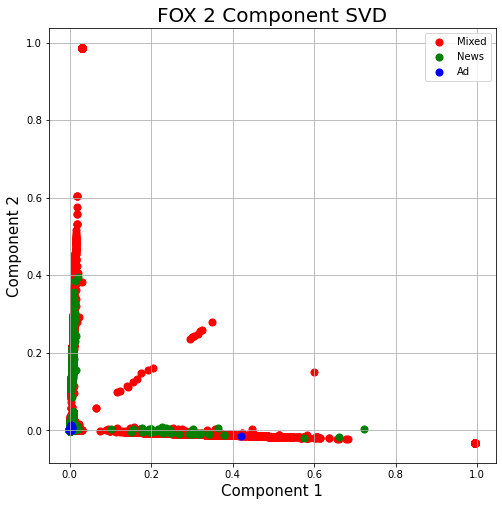

In [27]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Component 1', fontsize = 15)
ax.set_ylabel('Component 2', fontsize = 15)
ax.set_title('FOX 2 Component SVD', fontsize = 20)
targets = ['Mixed', 'News', 'Ad']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = X_new_df['Type'] == target
    ax.scatter(X_new_df.loc[indicesToKeep, 'Component 1']
               , X_new_df.loc[indicesToKeep, 'Component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

Well, this isn't a very interesting visualization, but also it was mostly to see if there were visual ways to separate these. 